# Diffusion Process Metrics Analysis

This notebook demonstrates how to analyze the diffusion process by tracking various quality and feature metrics at each timestep.

## What This Analyzes

- **Image Quality**: PSNR and sharpness
- **Features**: Edge strength, color variance, texture
- **Text Alignment**: CLIP similarity with prompt
- **Noise**: Variance and entropy of predicted noise

## Metrics Definitions

This analysis tracks **8 quantitative metrics** throughout the diffusion generation process to understand how image quality and features evolve from noise to the final image.

### Image Quality Metrics

**1. PSNR (Peak Signal-to-Noise Ratio)**
- **What it measures**: Overall image quality compared to pure noise
- **Formula**: $\text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right)$ where $\text{MSE} = \frac{1}{N}\sum(I - I_{\text{ref}})^2$
- **Interpretation**: Higher values = better quality. Typical range: 10-40 dB

**2. Sharpness (Laplacian Variance)**
- **What it measures**: How focused and clear the image appears
- **Formula**: $\text{Sharpness} = \text{Var}(\nabla^2 I)$ where $\nabla^2$ is the Laplacian operator
- **Interpretation**: Higher values = sharper edges and more detail

### Visual Feature Metrics

**3. Edge Strength (Sobel)**
- **What it measures**: Prominence and clarity of edges in the image
- **Formula**: $\text{Edge} = \text{mean}(\sqrt{G_x^2 + G_y^2})$ where $G_x, G_y$ are Sobel gradients
- **Interpretation**: Higher values = stronger, more defined edges

**4. Color Variance**
- **What it measures**: Diversity and richness of colors
- **Formula**: $\text{ColorVar} = \text{std}(I_{\text{RGB}})$ across all RGB channels
- **Interpretation**: Higher values = more colorful/diverse; lower = more monochromatic

**5. Texture Strength (High-Frequency)**
- **What it measures**: Amount of fine-grained detail and patterns
- **Formula**: $\text{Texture} = \text{mean}(|\mathcal{F}(I)|_{\text{high-freq}})$ via 2D FFT $\mathcal{F}$
- **Interpretation**: Higher values = more texture detail and complexity

### Text-Image Alignment

**6. CLIP Similarity**
- **What it measures**: How well the generated image matches the text prompt
- **Formula**: $\text{CLIP} = \frac{E_{\text{img}} \cdot E_{\text{text}}}{\|E_{\text{img}}\| \|E_{\text{text}}\|}$ (cosine similarity of embeddings)
- **Interpretation**: Range [-1, 1]; higher = better alignment with prompt

### Noise Characteristics

**7. Noise Variance**
- **What it measures**: Magnitude and spread of predicted noise
- **Formula**: $\text{NoiseVar} = \text{Var}(\epsilon_\theta(x_t, t, c))$ where $\epsilon_\theta$ is predicted noise
- **Interpretation**: Shows how "noisy" the model thinks each timestep should be

**8. Noise Entropy**
- **What it measures**: Randomness and information content of predicted noise
- **Formula**: $H = -\sum p_i \log_2(p_i)$ (Shannon entropy of discretized noise)
- **Interpretation**: Higher values = more random/unpredictable noise patterns

---

**Why These Metrics Matter:**
- Track quality improvement during generation
- Debug training issues (e.g., blurry outputs, poor text alignment)
- Compare different model configurations
- Tune guidance weight (w) for optimal results

## Setup and Imports

In [1]:
import torch
import clip
import matplotlib.pyplot as plt
from ddpm_clip.models import DDPM, UNet, EMA
from ddpm_clip.models.analysis import analyze_diffusion_metrics, plot_diffusion_metrics
from ddpm_clip.utils.config import load_config
from ddpm_clip.utils import load_checkpoint

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Model and CLIP

In [ ]:
# Load configuration
config = load_config('../config/model_default.yaml')
config = load_config('../config/test.yaml')

# Initialize CLIP
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
embed_size = 512

# Initialize DDPM
T = config['diffusion']['timesteps']
beta_start = config['diffusion']['beta_start']
beta_end = config['diffusion']['beta_end']
B = torch.linspace(beta_start, beta_end, T).to(device)
ddpm = DDPM(B, device)

print(f"Diffusion timesteps: {T}")
print(f"Beta range: {beta_start} to {beta_end}")

Diffusion timesteps: 400
Beta range: 0.0001 to 0.02


In [3]:
# Initialize model
model = UNet(
    T=T,
    img_ch=config['model']['img_channels'],
    img_size=config['model']['img_size'],
    down_chs=tuple(config['model']['down_channels']),
    t_embed_dim=config['model']['t_embed_dim'],
    c_embed_dim=config['model']['c_embed_dim']
).to(device)

# Create EMA object for loading if available
use_ema = config['training']['ema']['enabled']
if use_ema:
    ema = EMA(model, decay=config['training']['ema']['decay'])
else:
    ema = None

# Load checkpoint using the utility function from the package
checkpoint_epoch, loss_history = load_checkpoint(
    config=config,
    model=model,
    ema=ema
)

# If checkpoint was loaded, display info
if checkpoint_epoch > 0:
    print(f"\nModel loaded from epoch {checkpoint_epoch}")
    if loss_history:
        print(f"Training history:")
        print(f"  Final loss: {loss_history[-1]:.6f}")
        print(f"  Trained for {checkpoint_epoch} epochs")
    
    # Apply EMA weights if available
    if use_ema and ema is not None:
        print("Using EMA weights for generation")
        ema.apply_shadow()
    else:
        print("Using standard model weights (no EMA)")
else:
    raise FileNotFoundError(f"No checkpoint files found in {config.checkpoint_dir}. Please train a model first.")

model.eval()
print("\nModel loaded successfully and ready for analysis!")


Found checkpoint: ../model_checkpoint/clip_ddpm_default/99.pth
Automatically resuming training...
Resumed from epoch 100 with 100 loss values

Model loaded from epoch 100
Training history:
  Final loss: 0.045409
  Trained for 100 epochs
Using EMA weights for generation

Model loaded successfully and ready for analysis!
Resumed from epoch 100 with 100 loss values

Model loaded from epoch 100
Training history:
  Final loss: 0.045409
  Trained for 100 epochs
Using EMA weights for generation

Model loaded successfully and ready for analysis!


## Configure Analysis Parameters

### Understanding Generation Steps vs Timesteps

**Important Notation:**

In this notebook, we use **generation step t'** (t-prime) instead of the internal timestep t to make the progression more intuitive:

- **Generation Step t' = T - t**
  - **t' = 0**: Start of generation (pure noise)
  - **t' = T**: End of generation (final clean image)
  - Progression: **t' increases** from 0 → T as the image becomes clearer

This maps from the internal DDPM timestep convention:
- **Timestep t**:
  - **t = T-1**: Pure noise (start of reverse diffusion)
  - **t = 0**: Final clean image (end of reverse diffusion)
  - Progression: **t decreases** from T-1 → 0 during generation

**Why use t'?** It's more natural to think of generation as moving forward (0 → T) from noise to image, rather than backward (T-1 → 0).

In [4]:
# Analysis parameters
prompt = "A sport car"
w = 0.5  # Guidance weight
img_ch = config['model']['img_channels']
img_size = config['model']['img_size']

# Analyze every 10th timestep for efficiency
# NOTE: We use "generation step" t' = T - t for intuitive display:
#   - t' = 0 (start) = pure noise
#   - t' = T (end) = final clean image
# This maps from the internal timestep t where:
#   - t = T-1 (highest timestep) = pure noise
#   - t = 0 (lowest timestep) = final clean image
timesteps_to_analyze = list(range(0, T, 10))

print(f"Prompt: '{prompt}'")
print(f"Guidance weight: {w}")
print(f"Image size: {img_size}x{img_size}")
print(f"Timesteps to analyze: {len(timesteps_to_analyze)}")
print(f"Generation steps range: 0 (noise) to {T} (clean)")

Prompt: 'A sport car'
Guidance weight: 0.5
Image size: 32x32
Timesteps to analyze: 40
Generation steps range: 0 (noise) to 400 (clean)


## Run the Analysis

In [5]:
# Run metrics analysis
print("Running analysis... This may take a minute.")

metrics = analyze_diffusion_metrics(
    ddpm=ddpm,
    model=model,
    clip_model=clip_model,
    clip_preprocess=clip_preprocess,
    device=device,
    img_ch=img_ch,
    img_size=img_size,
    timesteps_to_analyze=timesteps_to_analyze,
    prompt=prompt,
    n_samples=16,
    w=w
)

print("Analysis complete!")

Running analysis... This may take a minute.
Analysis complete!
Analysis complete!


## Visualize Results

Showing 6 images from the diffusion process (noise → clean):
Generation steps t': [10, 80, 160, 240, 320, 400]


/var/scratch/ciarella/xAI/src/ddpm_clip/models/analysis.py:682: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


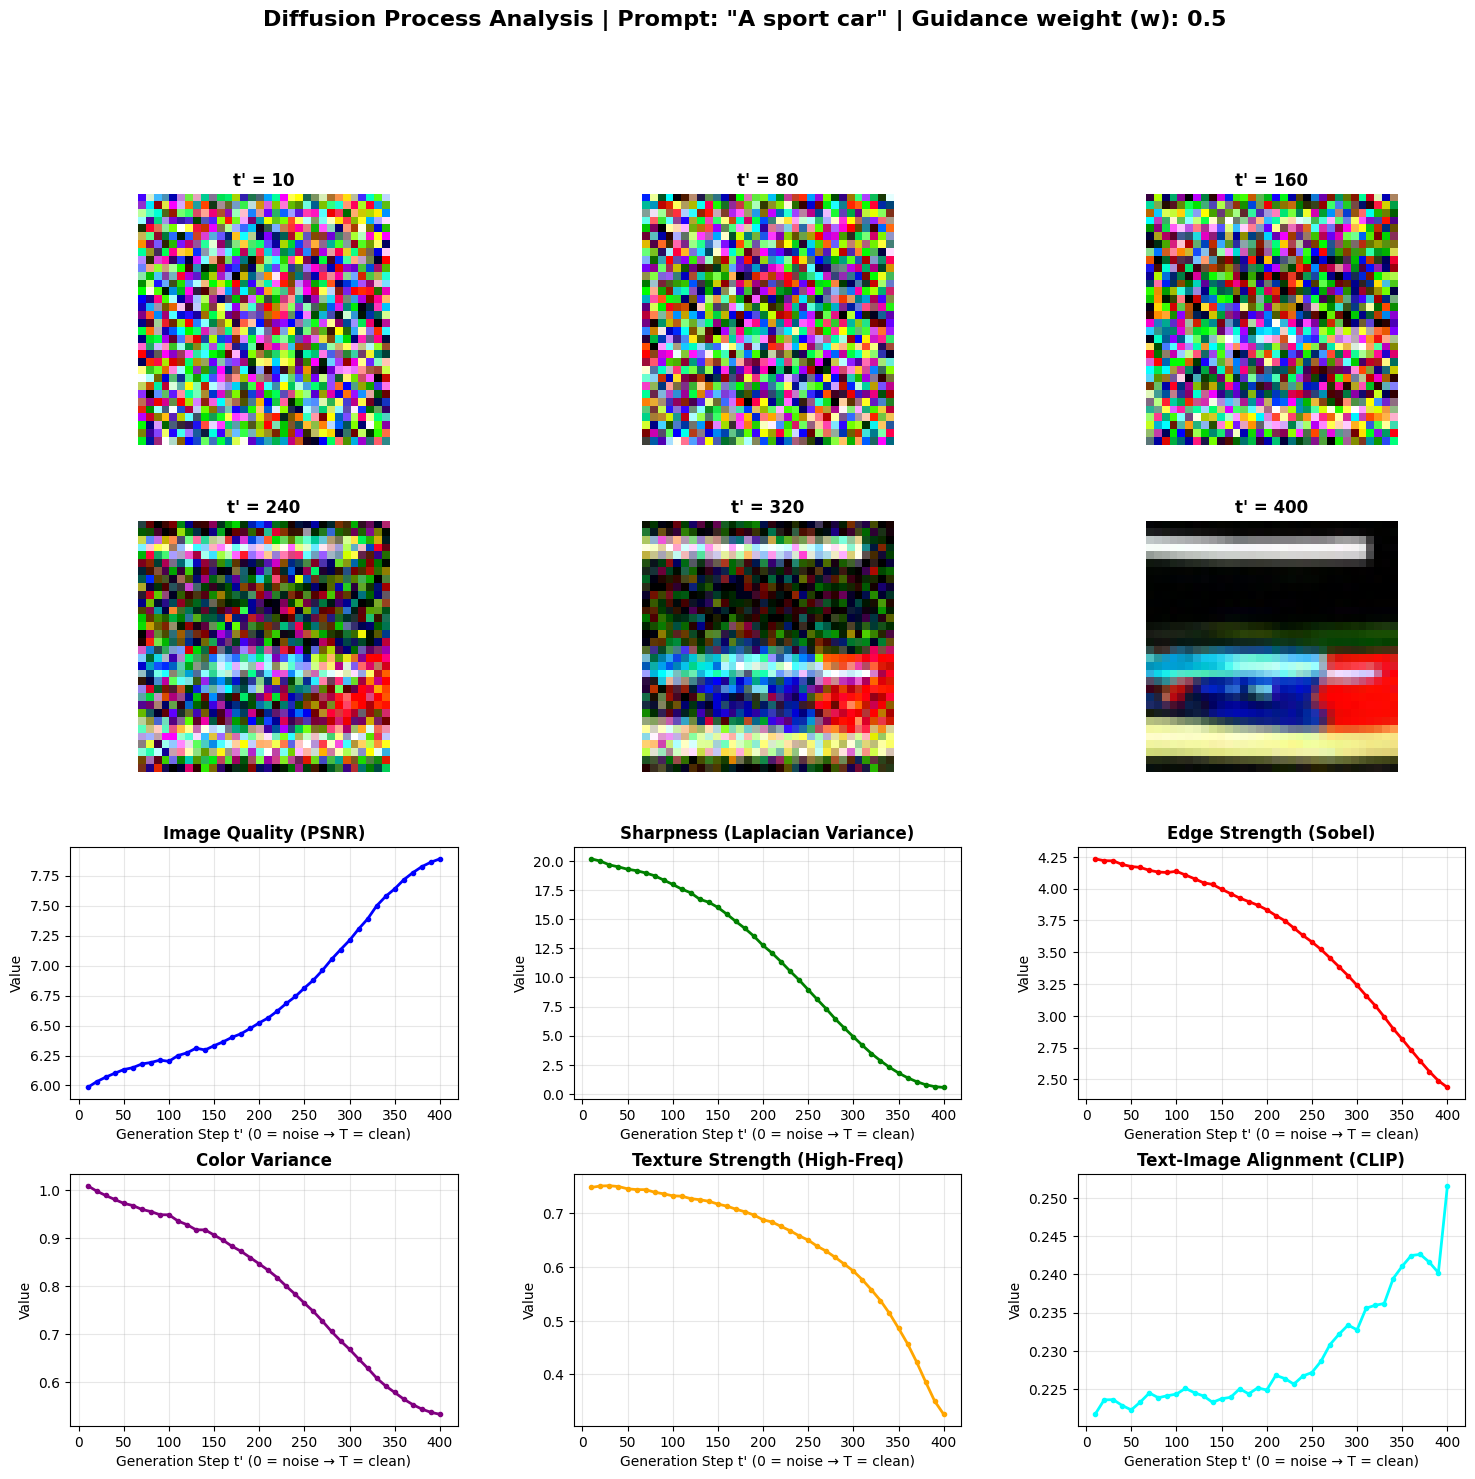

In [6]:
# Plot all metrics with diffusion images on top
# Select more images to show the progression (e.g., 6 images)
# NOTE: We display using "generation step" t' = T - t:
#   - t' = 0 = pure noise (start)
#   - t' = T = final clean image (end)
num_images = len(metrics['images'])
if num_images > 0:
    # Select 6 evenly spaced images
    num_display = min(6, num_images)
    image_indices = [int(i * (num_images - 1) / (num_display - 1)) for i in range(num_display)]
    
    # Create tuples of (image, generation_step)
    diffusion_images = [(metrics['images'][idx], metrics['generation_steps'][idx]) for idx in image_indices]
    
    print(f"Showing {num_display} images from the diffusion process (noise → clean):")
    print(f"Generation steps t': {[metrics['generation_steps'][idx] for idx in image_indices]}")
else:
    diffusion_images = None

fig = plot_diffusion_metrics(metrics, save_path=None, diffusion_images=diffusion_images, 
                              prompt=prompt, w=w)
plt.show()

## Analyze Prompt Alignment Over Time

This section analyzes how the generated image aligns with different prompts throughout the diffusion process. This helps understand:
- Which concepts emerge at different stages of generation
- How semantic alignment evolves from noise to final image
- Whether the model correctly associates related vs. unrelated concepts

In [7]:
from ddpm_clip.models.analysis import analyze_prompt_alignment, plot_prompt_alignment

# Define the generation prompt and alignment prompts to test
generation_prompt = "A sport car"
alignment_prompts = [generation_prompt, 'car', 'sport', 'fast', 'animal', 'red', 'tree', 'water']

print(f"Generation prompt: '{generation_prompt}'")
print(f"Testing alignment with: {alignment_prompts}")

# Analyze prompt alignment throughout diffusion
prompt_results = analyze_prompt_alignment(
    ddpm=ddpm,
    model=model,
    clip_model=clip_model,
    clip_preprocess=clip_preprocess,
    device=device,
    img_ch=img_ch,
    img_size=img_size,
    timesteps_to_analyze=timesteps_to_analyze,
    generation_prompt=generation_prompt,
    alignment_prompts=alignment_prompts,
    w=0.5,
    n_samples=16  # Average over 16 samples for robust estimates
)

print("Prompt alignment analysis complete!")

Generation prompt: 'A sport car'
Testing alignment with: ['A sport car', 'car', 'sport', 'fast', 'animal', 'red', 'tree', 'water']
Prompt alignment analysis complete!
Prompt alignment analysis complete!


/var/scratch/ciarella/xAI/src/ddpm_clip/models/analysis.py:903: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


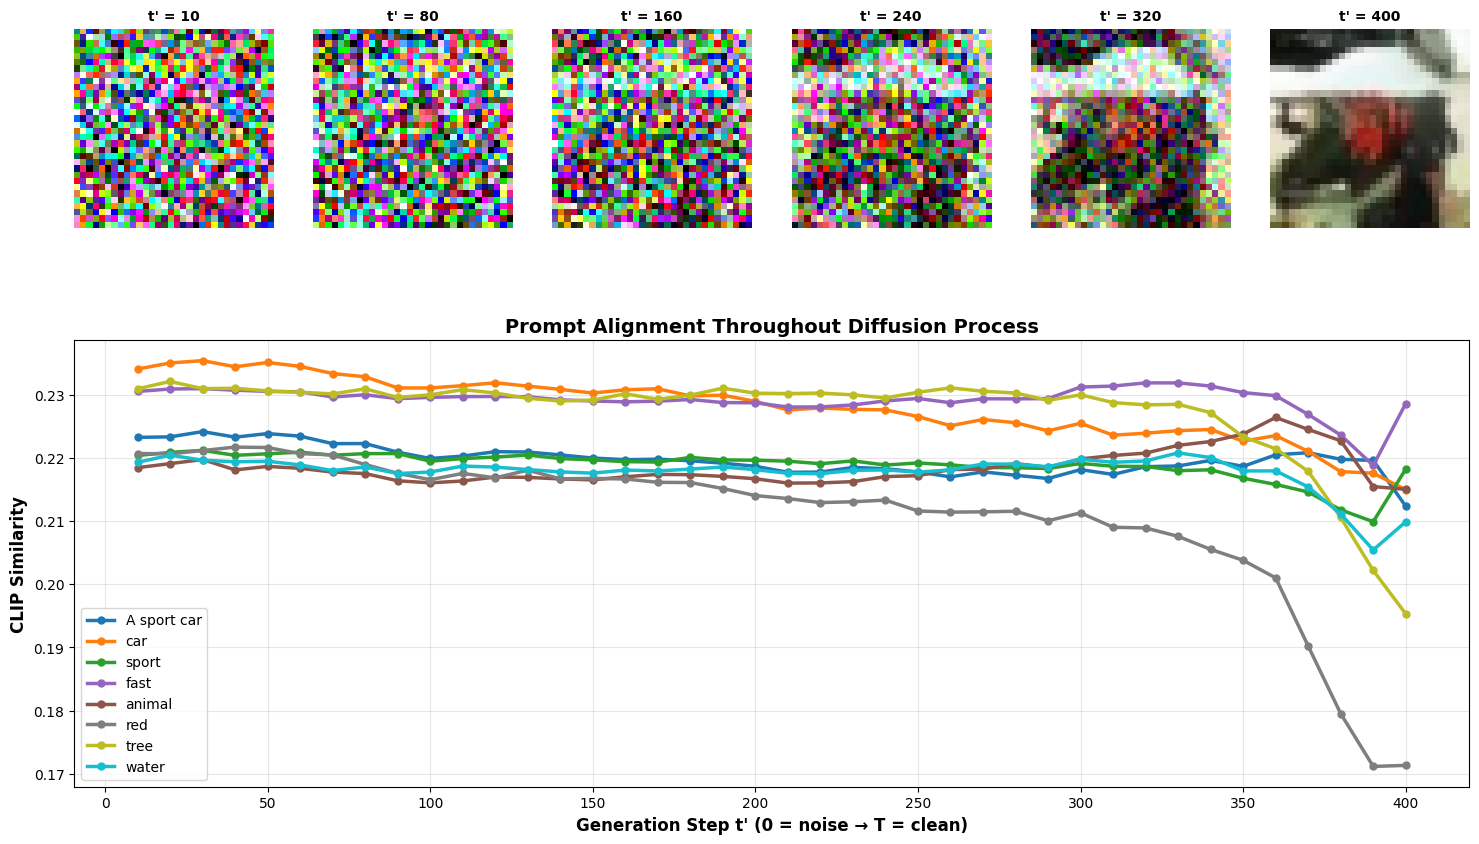

In [8]:
# Visualize the prompt alignment evolution
fig = plot_prompt_alignment(prompt_results, save_path=None, show_images=True, num_images=6)
plt.show()

### Interpretation

The plot above shows how CLIP similarity with different prompts evolves during the diffusion process:

- **Related concepts** (e.g., 'car', 'sport', 'vehicle', 'fast') should show **increasing similarity** as the image forms
- **Unrelated concepts** (e.g., 'animal', 'tree') should remain **low throughout** or even decrease
- **Color/attribute prompts** (e.g., 'red') may show varying patterns depending on the generated image

**What to look for:**
- Early timesteps (t' near 0): All similarities are low and similar (pure noise)
- Mid timesteps (t' ~100-300): Related concepts start differentiating from unrelated ones
- Final timesteps (t' near T): Clear separation between relevant and irrelevant prompts

## Compare Different Guidance Weights

In [9]:
# Compare different guidance weights
w_values = [0.0, 0.5, 1.0, 2.0]
results = {}

print("Analyzing different guidance weights...")
for w in w_values:
    print(f"  w = {w}")
    metrics_w = analyze_diffusion_metrics(
        ddpm=ddpm,
        model=model,
        clip_model=clip_model,
        clip_preprocess=clip_preprocess,
        device=device,
        img_ch=img_ch,
        img_size=img_size,
        timesteps_to_analyze=list(range(0, T, 10)),
        prompt=prompt,
        n_samples=16,
        w=w
    )
    results[w] = metrics_w

print("Done!")

Analyzing different guidance weights...
  w = 0.0
  w = 0.5
  w = 0.5
  w = 1.0
  w = 1.0
  w = 2.0
  w = 2.0
Done!
Done!


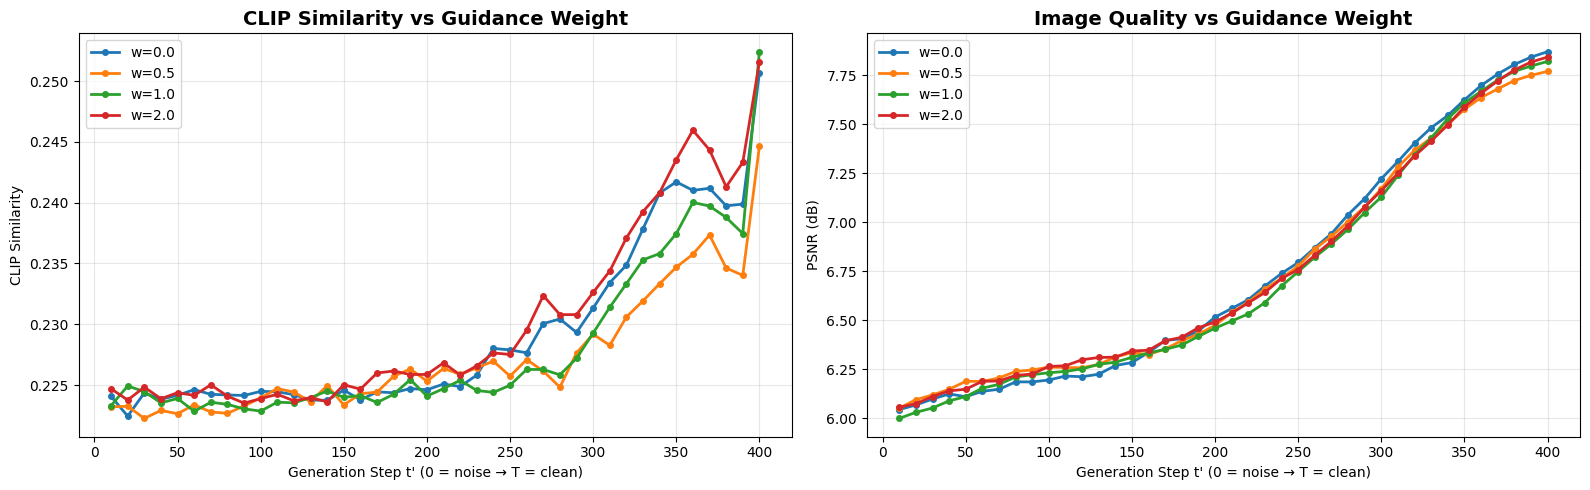

In [10]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Compare CLIP similarities
for w, metrics_w in results.items():
    axes[0].plot(metrics_w['generation_steps'], metrics_w['clip_similarity'], 
                 label=f'w={w}', marker='o', markersize=4, linewidth=2)
axes[0].set_title('CLIP Similarity vs Guidance Weight', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Generation Step t' (0 = noise → T = clean)")
axes[0].set_ylabel('CLIP Similarity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare image quality
for w, metrics_w in results.items():
    axes[1].plot(metrics_w['generation_steps'], metrics_w['image_quality'], 
                 label=f'w={w}', marker='o', markersize=4, linewidth=2)
axes[1].set_title('Image Quality vs Guidance Weight', fontsize=14, fontweight='bold')
axes[1].set_xlabel("Generation Step t' (0 = noise → T = clean)")
axes[1].set_ylabel('PSNR (dB)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()